# **Pre-processing technique: Reweighing for Statistical Parity**

Reweighing (Kamiran and Calders, 2012) is a pre-processing technique that amends the dataset to achieve statistical parity. The steps we will take are outlined below.

1. First, we will calculate Disparate Impact and Statistical Parity Difference metrics for our training dataset
2. Before we start using a predictive model, we will use the Reweighing technique on the full dataset just to explore how it works. This step should show that with the calculated weights assigned to the dataset, disparate impact and statistical parity difference are both removed. 
3. We will then apply the Reweighing method to data used to train a predictive model and observe the results.

This notebook contains gaps in the code for you to fill in.

# Install Libraries and load data

In [ ]:
# install AIF360
!pip install aif360
!pip install fairlearn

import pickle
import pandas as pd
import numpy as np
import seaborn as sns

from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing

from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.linear_model import RidgeClassifier


Load the data into a dataframe using pickle.load and print the dataframe to inspect it.

In [ ]:
# load data (amend this code to load the data from the correct file location)

with open(<file>, 'rb') as handle:
    df = pickle.load(handle)


In [ ]:
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,Gender_Female,Gender_Male,Ethnicity_Asian,Ethnicity_Black,Ethnicity_Hispanic,Ethnicity_White,Action
0,28.021737,4.351153,2.453895,1.637143,-1.746628,-0.483463,0.034170,1.399225,-0.795440,0.417474,0.214564,-0.471581,1.945645,-0.676217,1.213878,0.015701,1.472670,-0.054158,0.106858,-1.073194,-1.071848,-0.249942,0.634626,-0.732358,2.445728,0.784284,0.112329,1.055362,-0.605459,1.259140,-0.287927,0.214142,-0.644585,1.165376,-0.409198,-0.705823,0.091147,-0.953603,0.979086,0.745246,...,-0.178814,-0.145229,-0.040692,-0.046980,0.311939,-0.348202,0.271357,0.355443,-0.050447,-0.051816,0.083028,0.184139,0.107824,-0.083415,-0.359288,0.156547,-0.588539,-0.025777,-0.172269,0.331421,0.222768,-0.319124,-0.060476,-0.557444,-0.015627,-0.052749,-0.234189,-0.072384,0.090403,0.376761,0.258914,-0.050558,0.014513,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,29.603342,-3.407193,0.771800,-2.957411,0.599226,-2.805277,0.329414,-2.055339,-1.194446,-0.633159,2.268302,1.159443,0.899266,-0.472739,0.541605,-1.248643,0.046512,1.225688,0.456477,-1.483071,-0.944882,1.483229,0.512809,0.692537,0.178988,-1.609531,-1.985852,-0.469491,-1.156583,0.475535,-0.041015,-0.214832,-0.681641,1.131433,-0.667814,0.267111,-0.112433,1.094115,0.647188,0.134436,...,-0.108402,0.027760,-0.015238,0.027453,0.319960,-0.014589,-0.083241,-0.285702,0.047510,-0.144107,0.405289,-0.044139,-0.287215,0.201876,-0.298703,0.347969,0.029646,0.073052,-0.010259,0.023681,0.373202,-0.525402,-0.198727,-0.198440,-0.158843,0.191984,-0.004532,0.229210,-0.173042,-0.072871,0.442939,-0.054423,0.026959,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,26.504283,0.642464,2.522944,-2.197094,2.270646,-0.472510,0.532815,-0.266449,-0.131638,1.038315,-0.865827,-0.811267,-0.381401,-0.801701,-0.485021,0.656005,2.489571,-0.714447,0.658228,-0.075957,-1.159888,-2.334786,-0.253364,-2.073697,-0.939994,-1.177166,0.551689,-1.313316,-0.486217,0.732130,-0.320456,-1.143053,1.297522,-0.617038,0.340978,0.978603,0.398515,0.068011,-0.156836,-0.995878,...,-0.101136,0.042583,0.061005,0.304137,0.259210,-0.022425,0.138097,-0.442536,-0.108350,0.369865,0.151049,0.096285,0.013651,0.175281,0.144344,-0.006250,0.100850,-0.051642,0.122977,-0.088661,-0.229844,-0.272144,0.012633,0.423352,-0.033844,-0.125387,-0.483924,-0.116553,-0.113281,0.015519,0.017111,-0.012309,0.264572,1.0,0.0,0.0,0.0,1.0,0.0,1.0
3,25.012088,0.895121,-2.092517,3.687830,0.539642,1.988930,1.121646,2.255337,-0.128801,1.148379,1.616247,-2.599757,-0.322807,2.102508,-0.204551,0.069818,0.745222,-0.859875,-2.235995,-0.207436,-1.678697,-0.569024,-0.723122,-0.144833,-1.537487,1.678429,0.501249,-0.230747,0.746559,-0.069959,-0.346651,0.448291,0.283592,-0.445759,-0.529080,0.287333,0.466766,-0.411191,0.158602,-0.112038,...,-0.092894,-0.009915,-0.031731,0.153983,0.001281,0.123019,-0.035719,-0.045633,-0.103204,0.089567,0.104990,0.337228,-0.018783,-0.215437,0.268139,-0.125425,0.095183,-0.125172,-0.226467,0.371647,-0.023041,-0.093040,0.338300,-0.280392,0.046582,0.116709,0.133876,0.072716,0.124083,0.213735,-0.149901,-0.217130,0.004403,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,27.358934,-2.332423,0.154999,-2.623793,1.682456,1.262280,-1.685565,0.489319,-0.043471,-0.372265,1.778535,-1.145419,2.461327,1.396318,-0.911969,-2.228570,1.378633,-1.512325,-0.440331,-0.111163,-0.885884,-0.840501,1.576620,-0.972075,-2.008346,-0.358732,0.896535,0.562193,0.154542,-1.077315,1.902062,1.728109,0.317205,-0.436143,0.226549,-0.502206,-0.157102,-0.858722,-0.537544,-0.715195,...,0.039836,-0.168277,0.077232,0.193722,0.093298,-0.075132,-0.063202,0.120167,0.039270,0.350429,0.166559,0.130134,-0.181019,-0.193276,0.312204,-0.187331,-0.029194,-0.212277,-0.463872,0.041810,0.041185,-0.182479,-0.182461,-0.019350,-0.093371,0.003443,-0.025467,0.155397,-0.067609,-0.084833,0.033429,-0.199198,0.229629,0.0,1.0,0.0,0.0,1.0,0.0,1.0
...,.

#Calculate unwanted historic bias in our training data

Using AIF360, first create a Binary Label Dataset from the training data, then compute Disparate Impact and Statistical Parity Difference by creating a Binary Label Dataset Metric. Display a table showing the two metrics, alongside their target value (1 for Disparate Impact, 0 for Statistical Parity Difference)

Use the AIF360 documentation AIF360 for a [Binary Label Dataset](https://aif360.readthedocs.io/en/latest/modules/generated/aif360.datasets.BinaryLabelDataset.html) and for a [Binary Label Dataset Metric](https://aif360.readthedocs.io/en/latest/modules/generated/aif360.metrics.BinaryLabelDatasetMetric.html)


Set up variables for the privileged and unprivileged groups. In this example we will assign 'Ethnicity_White' as our privileged group. All other ethnicities are assigned as unprivileged.

In [ ]:
# Compute Disparate Impact and Statistical Parity Difference metrics for the original dataset, without Reweighing

# Set up variables for the privileged and unprivileged groups

prot = 'Ethnicity_White'
privileged_group = [{prot: 1}] 
unprivileged_group = [{prot: 0}]

# TODO: Create a Binary Label Dataset from the training data

# /TODO

# TODO: Compute fairness metrics on the original dataset without Reweighing

# /TODO



,Metric,Value,Target
0,Disparate Impact,0.898849,1
1,Statistical Parity Difference,-0.041552,0


# Apply Reweighing to the full dataset
Now, use the [Reweighing](https://aif360.readthedocs.io/en/latest/modules/generated/aif360.algorithms.preprocessing.Reweighing.html) technique to assign weights to each training data tuple. Then calculate the Disparate Impact and Statistical Parity metrics again for the pre-processed dataset and display in a table as you did above. You should see that each metric is very close to the target value, indicating that the method has been successful.

In [ ]:
# TODO: Use Reweighing to assign weights to each training data tuple

# /TODO


# TODO: Create a BinaryLabelDatasetMetric

# /TODO


In [ ]:
# TODO: Compute fairness metrics

# /TODO

,Metric,Value,Target
0,Disparate Impact,1.000000e+00,1
1,Statistical Parity Difference,-1.110223e-16,0


# Run a baseline predictive model without applying reweighing
So far, we have shown that the method to achieve statistical parity in the training data is successful. Now, we will build a standard Ridge Classifier and observe some baseline results, using the original data without Reweighing. 

Train a Ridge Classifier with 10 fold stratified cross validation. Compute performance metrics (Accuracy, Precision, Recall and F1 Score) and fairness metrics (Average Odds Difference, Equal Opportunity Difference, Disparate Impact, Statistical Parity Difference)

In [ ]:
# Instantiate the classifier (this code is ready to run, there are no gaps to fill)

model = RidgeClassifier()

# instantiate the cross-validation scheme
mv = StratifiedKFold(n_splits=10, shuffle=True, random_state=10)

# setup the performance metrics to be computed
perf_metrics = {"Accuracy": metrics.accuracy_score, 
                "Precision": metrics.precision_score, 
                "Recall": metrics.recall_score, 
                "F1-Score": metrics.f1_score, 
                }


In [ ]:
# Train a ridge regression classifier on the dataset before reweighing (this code is ready to run, there are no gaps to fill)
k, i = True, 1

# instantiating X
X = df.drop(labels=df.columns[-1], axis=1)

# instantiating the target variable
y = df[df.columns[-1]]

for (train, test) in mv.split(X, y):

    # Create a Binary Label Dataset
    dataset = X.iloc[train].copy()
    dataset[df.columns[-1]] = y.iloc[train]
    dataset_BLD = BinaryLabelDataset(df=dataset, label_names=['Action'], protected_attribute_names=[prot])

    # instantiating X
    X_train = pd.DataFrame(data = dataset_BLD.features, columns=df.columns[:-1]) 

    # instantiating y
    y_train = pd.DataFrame(data = dataset_BLD.labels.ravel())

    # fit model including sample weights calculated in reweighing
    model = model.fit(X_train, y_train)
    
    # get predictions in the test set
    ypred_class = model.predict(X.iloc[test])

    # compute performance metrics
    metrics = []
    dataset = X.iloc[test].copy()
    dataset[df.columns[-1]] = np.expand_dims(y.iloc[test], axis=1)
    dataset = BinaryLabelDataset(df=dataset, label_names=['Action'], protected_attribute_names=[prot])
    dataset_pred = X.iloc[test].copy()
    dataset_pred[df.columns[-1]] = np.expand_dims(ypred_class, axis=1)
    dataset_pred = BinaryLabelDataset(df=dataset_pred, label_names=['Action'], protected_attribute_names=[prot])
    metric_CM = ClassificationMetric(dataset, dataset_pred, privileged_groups=privileged_group, unprivileged_groups=unprivileged_group)
    for pf in perf_metrics.keys():
            metrics += [[pf, perf_metrics[pf](y.iloc[test].values.ravel(), ypred_class)]]
    
    # Compute fairness metrics
    metrics += [['Statistical Parity Difference', metric_CM.statistical_parity_difference()]]
    metrics += [['Equalized Odds Difference', metric_CM.average_odds_difference()]]
    metrics += [['False Negative Rate Difference', metric_CM.false_negative_rate_difference()]]

    # concatenate results
    df_m = pd.DataFrame(metrics, columns=["Metric", "Value"])
    df_m["Fold"] = i
    i += 1
    if k:
        df_metrics_orig = df_m.copy()
        k=0
    else:
        df_metrics_orig = pd.concat([df_metrics_orig, df_m.copy()], axis=0, ignore_index=True)

In [ ]:
# TODO: Display metrics

# /TODO


,mean,std
,Value,Value
Metric,,
Accuracy,0.712501,0.007711
Equalized Odds Difference,-0.051434,0.015280
F1-Score,0.589124,0.012598
False Negative Rate Difference,0.065355,0.031358
Precision,0.653016,0.012121
Recall,0.536745,0.015263
Statistical Parity Difference,-0.063249,0.012323


# Use our Reweighed data to train a predictive model

Amend your Ridge Classifier routine above to apply Reweighing to each fold of training data. Do not apply Reweighing at test time. Compute performance metrics (Accuracy, Precision, Recall and F1 Score) and fairness metrics (Average Odds Difference, Equal Opportunity Difference, Disparate Impact, Statistical Parity Difference)

In [ ]:
# Train a ridge regression classifier on the dataset after reweighing
k, i = True, 1

# instantiating X
X = df.drop(labels=df.columns[-1], axis=1)

# instantiating the target variable
y = df[df.columns[-1]]

for (train, test) in mv.split(X, y):

    # TODO: Reweigh the training data

    #/ TODO


    # instantiating the reweighed X
    X_train = #TODO

    # instantiating the reweighed y
    y_train = #TODO

    # instantiating the reweighing weights
    w_train = #TODO

    # fit model including sample weights calculated in reweighing
    model = model.fit(X_train, y_train, sample_weight = w_train.to_numpy().ravel())
    
    # get predictions in the test set
    ypred_class = model.predict(X.iloc[test])

    # compute performance metrics
    metrics = []
    dataset = X.iloc[test].copy()
    dataset[df.columns[-1]] = np.expand_dims(y.iloc[test], axis=1)
    dataset = BinaryLabelDataset(df=dataset, label_names=['Action'], protected_attribute_names=[prot])
    dataset_pred = X.iloc[test].copy()
    dataset_pred[df.columns[-1]] = np.expand_dims(ypred_class, axis=1)
    dataset_pred = BinaryLabelDataset(df=dataset_pred, label_names=['Action'], protected_attribute_names=[prot])
    metric_CM = ClassificationMetric(dataset, dataset_pred, privileged_groups=privileged_group, unprivileged_groups=unprivileged_group)
    for pf in perf_metrics.keys():
            metrics += [[pf, perf_metrics[pf](y.iloc[test].values.ravel(), ypred_class.ravel())]]
    
    # Compute fairness metrics
    metrics += [['Statistical Parity Difference', metric_CM.statistical_parity_difference()]]
    metrics += [['Equalized Odds Difference', metric_CM.average_odds_difference()]]
    metrics += [['False Negative Rate Difference', metric_CM.false_negative_rate_difference()]]

    # concatenate results
    df_m = pd.DataFrame(metrics, columns=["Metric", "Value"])
    df_m["Fold"] = i
    i += 1
    if k:
        df_metrics = df_m.copy()
        k=0
    else:
        df_metrics = pd.concat([df_metrics, df_m.copy()], axis=0, ignore_index=True)

In [ ]:
# TODO: Display metrics

# /TODO

,mean,std
,Value,Value
Metric,,
Accuracy,0.713978,0.007816
Equalized Odds Difference,-0.007049,0.014918
F1-Score,0.591378,0.012854
False Negative Rate Difference,0.010944,0.034097
Precision,0.655206,0.011927
Recall,0.538995,0.015436
Statistical Parity Difference,-0.021184,0.011293


# Present results to show the effectiveness of the Reweighing method

Present graphs (bar charts work well) to show how each performance and fairness metric differs for the baseline model compared with the application of Reweighing. Show the target line for each metric on the graph.

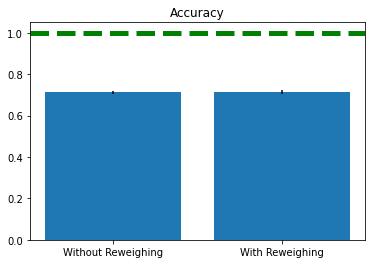

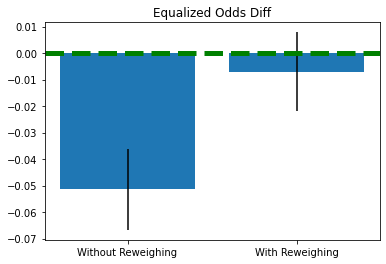

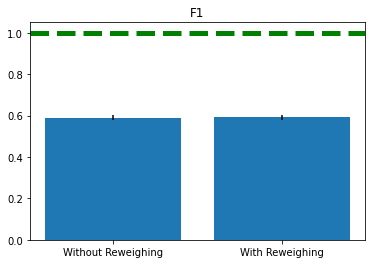

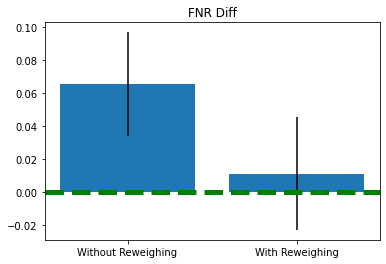

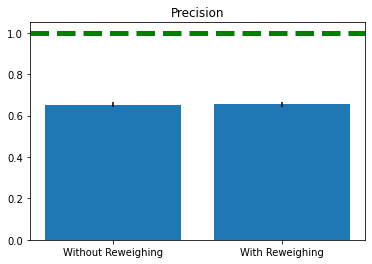

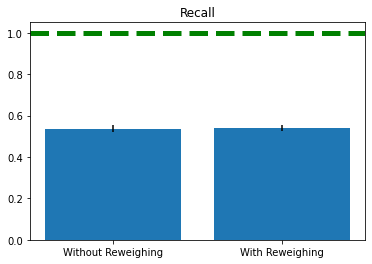

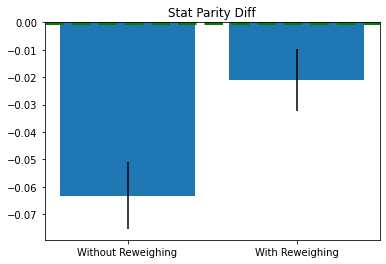

In [ ]:
# TODO: Present graphs to show each performance and fairness metrics

# /TODO